<span style="color:#F1B82D; font-size:40px;">112th Mizzou Homecoming: Blood Drive Data Analysis</span>

Hello!

This last year, I was on the Blood Drive Committee for Mizzou's Homecoming Steering Committee. As the Data Analyst, I worked to synthesize all of the data that was collected over a 7 month period. I created various procedures to collect data from Mizzou students and alumni, including the sign-up and check-in and out procedures. I have since consolidated the donation data into one Excel workbook for further analysis. The .xlsx source file we're analyzing has been cleaned of any personal or group-identifying data.

By the end of this project, my goal is to better understand the following questions I have about this 4-day blood drive:

    - What academic segments of Mizzou had the most successful donations?
    - Which parts of Mizzou's campus had the most successful donations?
    - Which groupings had the most successful donations?

This blood-drive ended as the Red Cross' 5th largest blood drive in history and took place in the midst of a national blood shortage. The Red Cross and our Blood Committee were able to collect 4,744 total units of blood, effectively saving 14,232 lives.

In [383]:
from IPython.display import HTML, display

html_code = """
<div style="display: flex; justify-content: space-between;">
    <img src="MizzouBloodDrive.jpg" alt="Mizzou Blood Drive" style="width: 600px; height: 400px;">
</div>
"""

display(HTML(html_code))


<span style="color:#F1B82D; font-size:30px;">Step 1: Import packages and establish the dataframe</span>


In [384]:
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.ExcelFile("Donation Data Copy.xlsx")
registered_df = df.parse("Registered_donors")
walk_in_df = df.parse('Walk-in_donors')
registered_df.head()

,Day,Full Name,Check-out,Donation Success,Donation Type,pawprint,Relationship,Chapter,Greek Grouping,Student Org,School/College,Dorm,NPHC Organization,Check-in Time,Check-out Time,Estimated Time Spent Donating
0,2023-10-09,NaN,YES,Unsuccessful,NaN,MIZ5497,Student,Greek Chapter 32,Greek Grouping 12,NaN,NaN,NaN,NaN,10:56:00,12:17:00,01:21:00
1,2023-10-09,NaN,YES,Unsuccessful,Power Red,MIZ6894,Student,Greek Chapter 32,Greek Grouping 12,NaN,NaN,NaN,NaN,10:56:00,12:29:00,01:33:00
2,2023-10-09,NaN,YES,Unsuccessful,Power Red,MIZ2638,Student,Greek Chapter 32,Greek Grouping 12,NaN,NaN,NaN,NaN,10:56:00,12:04:00,01:08:00
3,2023-10-09,NaN,YES,Unsuccessful,Regular,MIZ9685,Unknown,Greek Chapter 12,Greek Grouping 8,NaN,NaN,NaN,NaN,10:39:00,11:40:00,01:01:00
4,2023-10-09,NaN,YES,Unsuccessful,Power Red,MIZ3194,Student,Greek Chapter 6,Greek Grouping 6,NaN,NaN,NaN,NaN,11:01:00,12:11:00,01:10:00


In [385]:
# let's concatenate the two worksheets and set the axis to 0 to stack the two sheets vertically
masterdf = pd.concat([registered_df,walk_in_df], axis = 0)
masterdf = masterdf.rename(columns={'Check-in time':'Check-in Time'})
masterdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4737 entries, 0 to 1226
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Day                            4737 non-null   datetime64[ns]
 1   Full Name                      0 non-null      float64       
 2   Check-out                      4737 non-null   object        
 3   Donation Success               4686 non-null   object        
 4   Donation Type                  4730 non-null   object        
 5   pawprint                       3641 non-null   object        
 6   Relationship                   4737 non-null   object        
 7   Chapter                        4369 non-null   object        
 8   Greek Grouping                 4403 non-null   object        
 9   Student Org                    747 non-null    object        
 10  School/College                 1318 non-null   object        
 11  Dorm                  

In [386]:
# now, I want to make sure I'm only referring to the "successful donations" data.
# i'm going to copy into a new df, then filter for people who were successfully checked-out and who were listed as successful donations...
masterdf_successful = masterdf[:]
masterdf_successful = masterdf_successful[(masterdf_successful['Check-out'] == 'YES') & (masterdf_successful['Donation Success'] == 'Successful')]
masterdf_successful.info()  

# we have filtered for successful donations--

<class 'pandas.core.frame.DataFrame'>
Index: 3685 entries, 57 to 1226
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Day                            3685 non-null   datetime64[ns]
 1   Full Name                      0 non-null      float64       
 2   Check-out                      3685 non-null   object        
 3   Donation Success               3685 non-null   object        
 4   Donation Type                  3681 non-null   object        
 5   pawprint                       2896 non-null   object        
 6   Relationship                   3685 non-null   object        
 7   Chapter                        3414 non-null   object        
 8   Greek Grouping                 3442 non-null   object        
 9   Student Org                    598 non-null    object        
 10  School/College                 1020 non-null   object        
 11  Dorm                 

<span style="color:#F1B82D; font-size:30px;">Step 2: Understand the distribution of our (successful) donations</span>


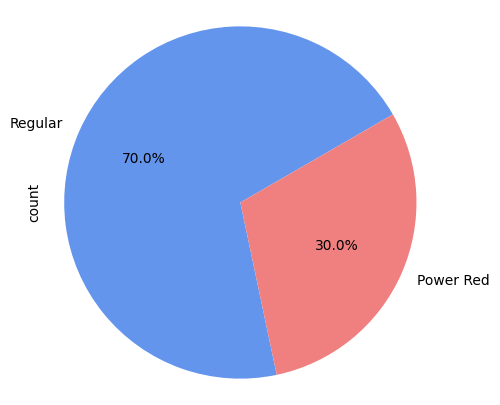

In [387]:
# first, let's analyze the distribution of Power Red and Regular donation types.
# i'm going to start by creating a new variable that holds all of the value counts for our ['Donation Type'] column.
donation_type_pie = masterdf_successful['Donation Type'].value_counts()
colors = ['#6495ED', '#F08080']

donation_type_pie.plot(kind='pie', figsize=(5, 5), colors=colors, autopct='%1.1f%%', startangle=30)

# here, we'll use myplotlib.pyplot to set the aspect ratio to equal.
plt.axis('equal')

plt.show()

<span style="color:#F1B82D; font-size:30px;">Step 3: Understand the distribution of donations across different Greek organizations </span>


In [388]:
# let's create a custom function that can sort based on the last integer values in each item. 
def custom_sort_key(s):
    # Checks if the value is a string before attempting to extract numeric part
    if isinstance(s, str):
        return int(''.join(filter(str.isdigit, s)))
    else:
        # Place string values at the end of list
        return float('inf')

# now, we can sort using this function
greek_chapters = pd.unique(masterdf_successful['Chapter'])
greek_chapters_sorted = sorted(greek_chapters, key=custom_sort_key)

greek_groupings = pd.unique(masterdf_successful['Greek Grouping'])
greek_groupings_sorted = sorted(greek_groupings, key=custom_sort_key)

for chapter in greek_chapters_sorted:
    if chapter == "Greek Chapter 1":
        print("Here are the greek chapters:\n ")
        print(chapter)
    elif pd.isna(chapter):
        pass
    else:
        print(chapter)

print('\n')

for grouping in greek_groupings_sorted:
    if grouping == "Greek Grouping 1":
        print("Here are the greek groupings:\n ")
        print(grouping)
    elif pd.isna(grouping):
        pass
    else:
        print(grouping)

# Now we can easily see the list of different Greek organizations. We had 36 greek chapters participate and they were in 14 different groups.

Here are the greek chapters:
 
Greek Chapter 1
Greek Chapter 2
Greek Chapter 3
Greek Chapter 4
Greek Chapter 5
Greek Chapter 6
Greek Chapter 7
Greek Chapter 8
Greek Chapter 9
Greek Chapter 10
Greek Chapter 11
Greek Chapter 12
Greek Chapter 13
Greek Chapter 14
Greek Chapter 15
Greek Chapter 16
Greek Chapter 17
Greek Chapter 18
Greek Chapter 19
Greek Chapter 20
Greek Chapter 21
Greek Chapter 22
Greek Chapter 23
Greek Chapter 24
Greek Chapter 25
Greek Chapter 26
Greek Chapter 27
Greek Chapter 28
Greek Chapter 29
Greek Chapter 30
Greek Chapter 31
Greek Chapter 32
Greek Chapter 33
Greek Chapter 34
Greek Chapter 35
Greek Chapter 36


Here are the greek groupings:
 
Greek Grouping 1
Greek Grouping 2
Greek Grouping 3
Greek Grouping 4
Greek Grouping 5
Greek Grouping 6
Greek Grouping 7
Greek Grouping 8
Greek Grouping 9
Greek Grouping 10
Greek Grouping 11
Greek Grouping 12
Greek Grouping 13
Greek Grouping 14


In [389]:
# i also want to get the number of donations that each of these chapters / groupings donated during the blood drive.
# i'll create a new column called donations, and allocate 1 point for 'regular' donations and 2 points for 'power red' donations.
masterdf_successful['Donations'] = 0

# if a student donated 'Regular', then they donated 1 unit. If they donated 'Power Red', they donated 2 units.
masterdf_successful.loc[(masterdf_successful['Donation Type'] == 'Regular'), 'Donations'] = 1
masterdf_successful.loc[(masterdf_successful['Donation Type'] == 'Power Red'), 'Donations'] = 2

# our ['Donations'] column is correctly tracking the number of donations we received!

In [390]:
# now, let's count all the donations that each chapter / grouping accumulated.
chapters_total_donations = {}
groupings_total_donations = {}

for chapter in greek_chapters_sorted:
    total_donations = masterdf_successful[masterdf_successful['Chapter'] == chapter]['Donations'].sum()
    chapters_total_donations[chapter] = total_donations
    print(f"{chapter} : {total_donations}")

for grouping in greek_groupings_sorted:
    total_donations = masterdf_successful[masterdf_successful['Greek Grouping'] == grouping]['Donations'].sum()
    groupings_total_donations[grouping] = total_donations
    print(f"{grouping} : {total_donations}")

Greek Chapter 1 : 95
Greek Chapter 2 : 155
Greek Chapter 3 : 143
Greek Chapter 4 : 67
Greek Chapter 5 : 104
Greek Chapter 6 : 83
Greek Chapter 7 : 225
Greek Chapter 8 : 61
Greek Chapter 9 : 2
Greek Chapter 10 : 44
Greek Chapter 11 : 59
Greek Chapter 12 : 309
Greek Chapter 13 : 288
Greek Chapter 14 : 377
Greek Chapter 15 : 269
Greek Chapter 16 : 158
Greek Chapter 17 : 206
Greek Chapter 18 : 263
Greek Chapter 19 : 120
Greek Chapter 20 : 126
Greek Chapter 21 : 149
Greek Chapter 22 : 130
Greek Chapter 23 : 69
Greek Chapter 24 : 103
Greek Chapter 25 : 23
Greek Chapter 26 : 208
Greek Chapter 27 : 40
Greek Chapter 28 : 105
Greek Chapter 29 : 41
Greek Chapter 30 : 31
Greek Chapter 31 : 23
Greek Chapter 32 : 204
Greek Chapter 33 : 41
Greek Chapter 34 : 100
Greek Chapter 35 : 19
Greek Chapter 36 : 26
nan : 0
Greek Grouping 1 : 136
Greek Grouping 2 : 317
Greek Grouping 3 : 406
Greek Grouping 4 : 375
Greek Grouping 5 : 148
Greek Grouping 6 : 144
Greek Grouping 7 : 394
Greek Grouping 8 : 514
Greek 

In [391]:
# we also need to know how many members were in each grouping. to add context, here are some generated numbers for each grouping.
grouping_membership_totals = {
    'Greek Grouping 1': 395,
    'Greek Grouping 2': 383,
    'Greek Grouping 3': 434,
    'Greek Grouping 4': 454,
    'Greek Grouping 5': 480,
    'Greek Grouping 6': 440,
    'Greek Grouping 7': 474,
    'Greek Grouping 8': 442,
    'Greek Grouping 9': 474,
    'Greek Grouping 10': 305,
    'Greek Grouping 11': 374,
    'Greek Grouping 12': 456,
    'Greek Grouping 13': 477,
    'Greek Grouping 14': 446
}

for grouping, total in grouping_membership_totals.items():
    grouping_df = masterdf_successful[masterdf_successful['Greek Grouping'] == grouping]
    total_donations = grouping_df['Donations'].sum()
    percentage = (total_donations / total) * 100
    percentage = round(percentage,2)
    grouping_membership_totals[grouping] = percentage


Total donations across all greek groupings: 4508


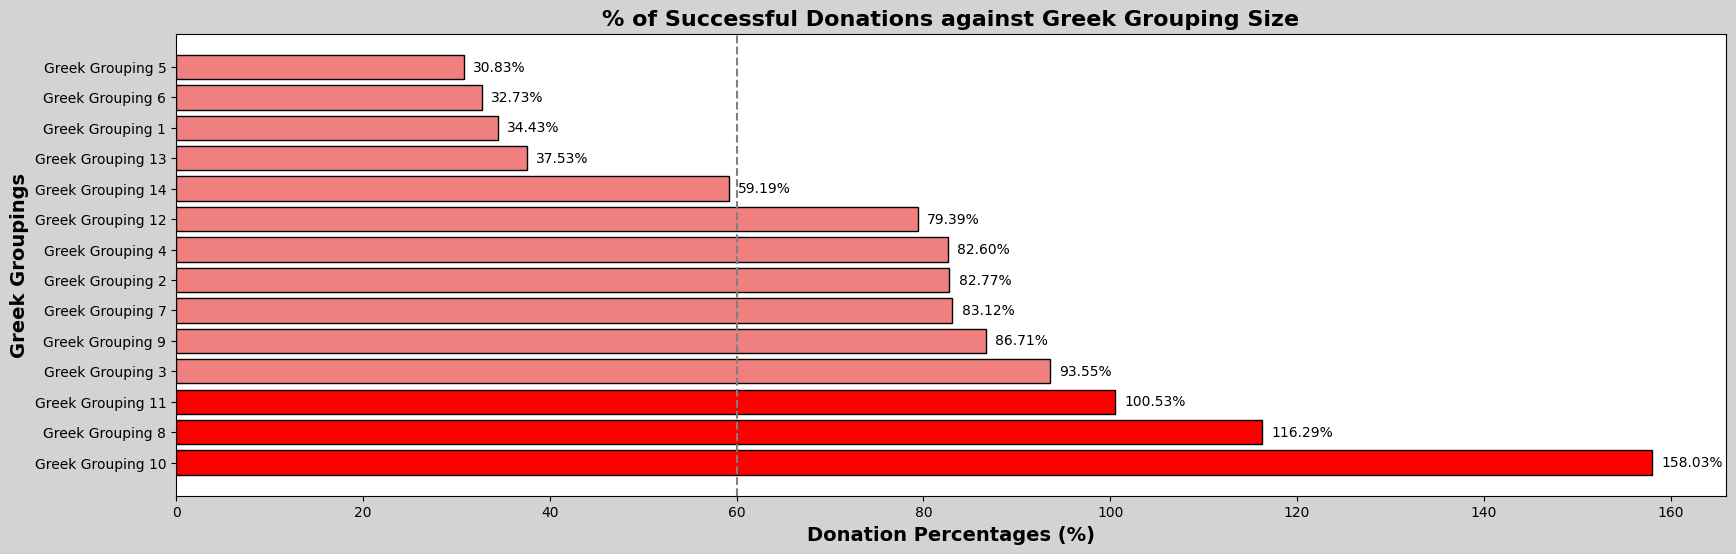

In [392]:
# now we can start to create some visualizations of our data.
sorted_grouping_donations = {k: v for k, v in sorted(grouping_membership_totals.items(), key=lambda item: item[1], reverse=True)}

tsum = sum(groupings_total_donations.values())
print('Total donations across all greek groupings:',tsum)

groupings = list(sorted_grouping_donations.keys())
percentages = list(sorted_grouping_donations.values())

# here we'll create the bar chart
plt.figure(figsize=(20,6), facecolor='lightgray')
colors = ['red' if v > 100 else 'lightcoral' for v in percentages]

plt.barh(groupings,percentages,color=colors,edgecolor='black')
plt.xlabel('Donation Percentages (%)', fontsize=14, fontweight='bold',color='black')
plt.ylabel('Greek Groupings', fontsize=14, fontweight='bold',color='black')
plt.title('% of Successful Donations against Greek Grouping Size', fontsize=16, fontweight='bold', color='black')
plt.axvline(x=60,color='gray',linestyle='--')

for i, v in enumerate(percentages):
    plt.text(v + 1, i, f'{v:.2f}%', va='center')

plt.show()

<span style="color:#F1B82D; font-size:30px;">Step 4: Understand the distribution of donations between all Mizzou colleges and schools </span>


In [393]:
# establish college dict:
colleges_schools_dict = {}

# correct / filter data:
masterdf_successful = masterdf_successful[(masterdf_successful['School/College'] != 'x') & (~masterdf_successful['School/College'].isna())]

# create donations column:
masterdf_successful['Donations'] = 0

# allocate donation counts to the 'School/College' donations:
masterdf_successful.loc[masterdf_successful['Donation Type'] == 'Power Red', 'Donations'] = 2
masterdf_successful.loc[masterdf_successful['Donation Type'] == 'Regular', 'Donations'] = 1

# iterate through unique college/school names:
for college in masterdf_successful['School/College'].unique():
    college_df = masterdf_successful.loc[masterdf_successful['School/College'] == college]
    total_college_donations = college_df['Donations'].sum()
    colleges_schools_dict[college] = total_college_donations

# sort the colleges by total donations in descending order:
sorted_colleges = {k: v for k, v in sorted(colleges_schools_dict.items(), key=lambda item: item[1], reverse=True)}

print(sorted_colleges)


{'Trulaske College of Business': 373, 'College of Arts and Science': 180, 'College of Health Science': 178, 'College of Agriculture, Food and Natural Resources': 164, 'College of Engineering': 150, 'Missouri School of Journalism': 129, 'Sinclair School of Nursing': 99, 'College of Education and Human Development': 46, 'School of Law': 12, 'College of Veterinary Medicine': 7}


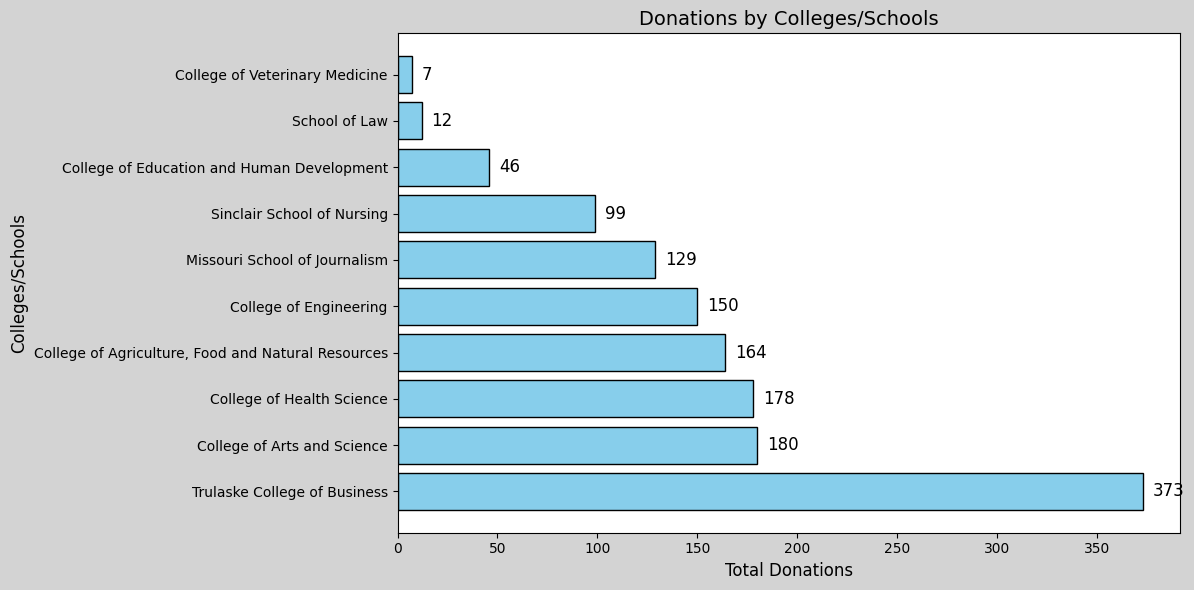

In [394]:
colleges = list(sorted_colleges.keys())
colleges = [str(college) for college in colleges]
donations = list(sorted_colleges.values())

# create the chart:
plt.figure(figsize=(12, 6), facecolor='lightgray')  # Adjust the figure size as needed
plt.barh(colleges, donations, color='skyblue', edgecolor='black')
plt.xlabel('Total Donations', fontsize=12)
plt.ylabel('Colleges/Schools', fontsize=12)
plt.title('Donations by Colleges/Schools', fontsize=14)

# add labels:
for i, donation_count in enumerate(donations):
    plt.text(donation_count + 5, i, f'{int(donation_count)}', va='center', fontsize=12)

# make the labels fit
plt.tight_layout()  
plt.show()

<span style="color:#F1B82D; font-size:30px;">Step 5: Understand the distribution of donations across the different Mizzou dorms </span>


In [395]:
# some more data cleaning here:
masterdf_successful['Dorm'] = masterdf_successful['Dorm'].replace('Defore-Graham', 'Defoe-Graham')

# establish dict, filter, and sort!
dorm_dict = {}

filtered_masterdf3 = masterdf_successful[~masterdf_successful['Dorm'].isna() & (masterdf_successful['Dorm'] != 'Defoe-Graham')]

for dorm in filtered_masterdf3['Dorm'].unique():
    dorm_df = filtered_masterdf3[filtered_masterdf3['Dorm'] == dorm]
    total_dorm_donations = dorm_df['Donations'].sum()
    dorm_dict[dorm] = total_dorm_donations

sorted_dorms = sorted(dorm_dict.items(), key=lambda item: item[1], reverse=True)

dorms = [k for k, v in sorted_dorms]
donations = [v for k, v in sorted_dorms]

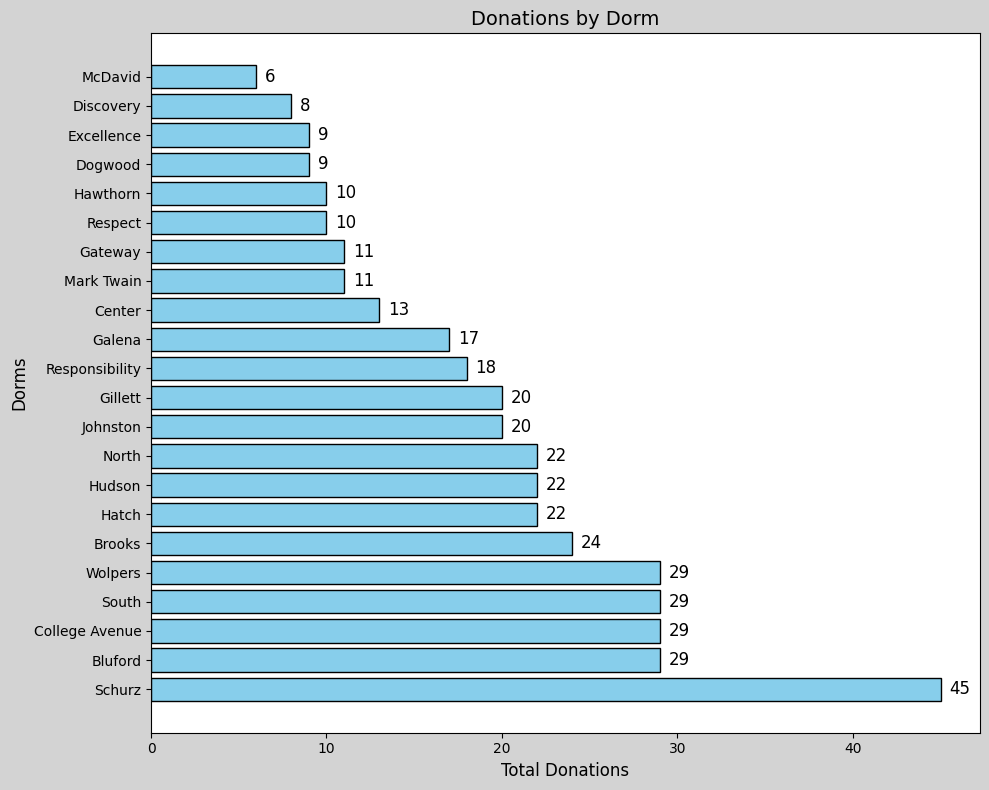

In [396]:
# let's create another bar chart that shows us the amount of donations across all of the dorms we have here at Mizzou.
plt.figure(figsize=(10, 8), facecolor='lightgray')

plt.barh(dorms, donations, color='skyblue', edgecolor='black')

plt.xlabel('Total Donations', fontsize=12)
plt.ylabel('Dorms', fontsize=12)
plt.title('Donations by Dorm', fontsize=14)

for i, donation_count in enumerate(donations):
    plt.text(donation_count + .5, i, f'{int(donation_count)}', va='center', fontsize=12)

plt.tight_layout()
plt.show()

College Crossing had the most donations!


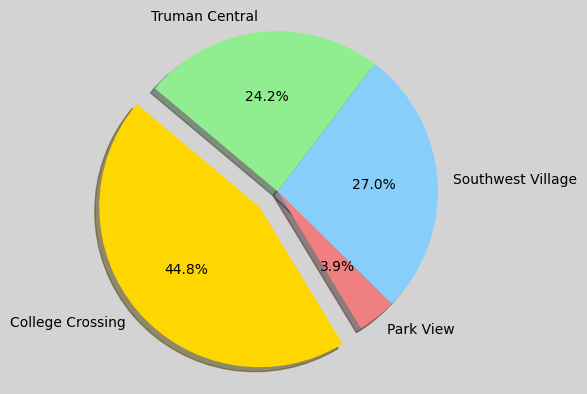

In [397]:
# now, let's create a few lists that group all of our dorms into their respective neighborhoods:
college_crossing = ['College Avenue', 'Discovery', 'Excellence', 'Gateway', 'Gillett', 'Hatch', 'Hudson', 'Respect', 'Responsibility', 'Schurz']
park_view = ['Mark Twain', 'McDavid']
southwest_village = ['Bluford', 'Brooks', 'Center', 'North', 'South']
truman_central = ['Defoe-Graham', 'Dogwood', 'Galena', 'Hawthorn', 'Johnston', 'Wolpers']

# create a dictionary to store the total donations for each grouping:
dorm_donations = {
    'College Crossing': masterdf_successful[masterdf_successful['Dorm'].isin(college_crossing)]['Donations'].sum(),
    'Park View': masterdf_successful[masterdf_successful['Dorm'].isin(park_view)]['Donations'].sum(),
    'Southwest Village': masterdf_successful[masterdf_successful['Dorm'].isin(southwest_village)]['Donations'].sum(),
    'Truman Central': masterdf_successful[masterdf_successful['Dorm'].isin(truman_central)]['Donations'].sum()
}

# to find the most donations:
most_donations_group = max(dorm_donations, key=dorm_donations.get)
print(f"{most_donations_group} had the most donations!")

# pie chart!
labels = dorm_donations.keys()
sizes = dorm_donations.values()
colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen']
explode = (0.15, 0, 0, 0)  # To explode a slice if needed

fig, ax = plt.subplots(facecolor='lightgray')

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# this data does include how many people live in each dorm, and it was data I was unable to collect as a student. This is just a neat visual to see which dorms donated the absolute most.